In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Final steps').getOrCreate()
from pyspark import SparkContext, SparkConf
sp = SparkConf().setAppName('Final steps').setMaster("local[*]")
sc = SparkContext.getOrCreate(spark)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.regression import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = spark.read.csv('Department 37 prepped.csv', header=True, inferSchema=True)

# 4.2

In [3]:
df = df.drop("_c0") #column was created by writing to csv in previous step, not required now
df.show(5)

+------+-------+-------------------+--------------------+----------+--------+------+--------------------+----------+-------------------+--------------------+----------+----------+--------------------+
|OffSex|OffRace|INCIDENT_DATE_LESS_|     OFF_INJURE_DESC|OFF_HOSPIT| CitRace|CitSex|    SUBJ_INJURE_DESC|CIT_ARREST|         CIT_INFL_A|          CITChargeT|SERVICE_TY|UOF_REASON|          ForceType1|
+------+-------+-------------------+--------------------+----------+--------+------+--------------------+----------+-------------------+--------------------+----------+----------+--------------------+
|  Male|  Black|                  2|No injuries noted...|        No|   Black|Female|Non-Visible Injur...|       Yes|  Mentally unstable|               APOWW|    Arrest|    Arrest|Hand/Arm/Elbow St...|
|  Male|  White|                 17|       Sprain/Strain|       Yes|Hispanic|  Male|No injuries noted...|       Yes|  Mentally unstable|               APOWW|    Arrest|    Arrest|         Joint Lo

In [4]:
encodeddf = df
x = df.columns
x.remove("INCIDENT_DATE_LESS_") #already numerical
x.remove("CitSex") #this field throws errors while encoding hence must be encoded manually
for i in x:
    ic = i
    oc = i+" encoded"
    indexer = StringIndexer(inputCol=ic, outputCol=oc)
    encodeddf = indexer.fit(encodeddf).transform(encodeddf)

In [5]:
y = [i for i in encodeddf.columns if i not in x] #storing only those columns which are numerical
encodeddf = encodeddf[y]

In [6]:
encodeddf = encodeddf.withColumn("CitSex encoded", when(df["CitSex"] == "Male", 1.0).otherwise(2.0)) #only two genders

In [7]:
encodeddf = encodeddf.drop("CitSex")
encodeddf.show(5)

+-------------------+--------------+---------------+-----------------------+------------------+---------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+
|INCIDENT_DATE_LESS_|OffSex encoded|OffRace encoded|OFF_INJURE_DESC encoded|OFF_HOSPIT encoded|CitRace encoded|SUBJ_INJURE_DESC encoded|CIT_ARREST encoded|CIT_INFL_A encoded|CITChargeT encoded|SERVICE_TY encoded|UOF_REASON encoded|ForceType1 encoded|CitSex encoded|
+-------------------+--------------+---------------+-----------------------+------------------+---------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+
|                  2|           0.0|            2.0|                    0.0|               0.0|            0.0|                     4.0|               0.0|               0.0|               0.0|         

Now we can use VectorAssembly to convert the dataframe into a (features, labels) vector. "CIT_ARREST encoded" is the label.

In [8]:
af = VectorAssembler(inputCols = ['INCIDENT_DATE_LESS_', 'OffSex encoded', 'OffRace encoded', 'OFF_INJURE_DESC encoded',
 'OFF_HOSPIT encoded', 'CitRace encoded', 'SUBJ_INJURE_DESC encoded', 'CIT_INFL_A encoded', 'CITChargeT encoded', 
                                  'SERVICE_TY encoded', 'UOF_REASON encoded', 'ForceType1 encoded', 'CitSex encoded'], 
                     outputCol = "features")

In [9]:
output = af.transform(encodeddf)

In [10]:
final = output.select("features", "CIT_ARREST encoded")

In [11]:
final.show(5)

+--------------------+------------------+
|            features|CIT_ARREST encoded|
+--------------------+------------------+
|(13,[0,2,6,11,12]...|               0.0|
|(13,[0,3,4,5,11,1...|               0.0|
|(13,[0,2,5,7,11,1...|               0.0|
|[24.0,0.0,2.0,0.0...|               0.0|
|(13,[0,7,8,12],[7...|               0.0|
+--------------------+------------------+
only showing top 5 rows



In [11]:
(trainingData, testData) = final.randomSplit([0.7, 0.3]) #this code is used again in 7.1

# 6.3

In [13]:
#area under ROC curve is used to determine the best value for tree depth
for i in range(2,11):
    dt = DecisionTreeClassifier(labelCol="CIT_ARREST encoded", featuresCol="features", maxDepth=i, maxBins=552)
    model = dt.fit(trainingData)
    pred = model.transform(testData)
    binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
    print("Area under curve:", binev.evaluate(pred))
    mev = MulticlassClassificationEvaluator(labelCol="CIT_ARREST encoded", predictionCol="prediction", metricName="accuracy")
    print("Accuracy:", mev.evaluate(pred))

Area under curve: 0.8513157894736842
Accuracy: 0.821173104434907
Area under curve: 0.8462181944928547
Accuracy: 0.821173104434907
Area under curve: 0.8794179156500523
Accuracy: 0.8226037195994278
Area under curve: 0.9207127919135587
Accuracy: 0.8569384835479256
Area under curve: 0.9402230742418962
Accuracy: 0.8569384835479256
Area under curve: 0.9428546531892645
Accuracy: 0.8597997138769671
Area under curve: 0.9288166608574415
Accuracy: 0.8497854077253219
Area under curve: 0.9247995817357966
Accuracy: 0.8483547925608012
Area under curve: 0.924860578598815
Accuracy: 0.8426323319027181


In [13]:
#area under ROC curve is used to determine the best value for tree depth
for i in range(50,500,50): #increasing number of trees by 50 each time
    rf = RandomForestClassifier(labelCol="CIT_ARREST encoded", featuresCol="features", numTrees=i, maxDepth=4, maxBins=552)
    model = rf.fit(trainingData)
    pred = model.transform(testData)
    binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
    print("Area under curve:", binev.evaluate(pred))
    mev = MulticlassClassificationEvaluator(labelCol="CIT_ARREST encoded", predictionCol="prediction", metricName="accuracy")
    print("Accuracy:", mev.evaluate(pred))

Area under curve: 0.9182284934654653
Accuracy: 0.8099861303744799
Area under curve: 0.9206520178084209
Accuracy: 0.8072122052704577
Area under curve: 0.9202929771650195
Accuracy: 0.811373092926491
Area under curve: 0.9216932356742831
Accuracy: 0.8085991678224688
Area under curve: 0.9223754128967445
Accuracy: 0.8085991678224688
Area under curve: 0.922806261668825
Accuracy: 0.811373092926491
Area under curve: 0.9259299152664112
Accuracy: 0.8085991678224688
Area under curve: 0.9242244722102582
Accuracy: 0.8085991678224688
Area under curve: 0.9207597300014405
Accuracy: 0.8085991678224688


In [12]:
#area under ROC curve is used to determine the best values
for i in range(10,100,10): #increasing number of iterations by 10 each time
    lr = LogisticRegression(labelCol="CIT_ARREST encoded", featuresCol="features", maxIter=i, family="binomial")
    model = lr.fit(trainingData)
    pred = model.transform(testData)
    binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
    print("Area under curve:", binev.evaluate(pred))
    mev = MulticlassClassificationEvaluator(labelCol="CIT_ARREST encoded", predictionCol="prediction", metricName="accuracy")
    print("Accuracy:", mev.evaluate(pred))

Area under curve: 0.8318364197530889
Accuracy: 0.8636363636363636
Area under curve: 0.828641975308643
Accuracy: 0.8636363636363636
Area under curve: 0.8285802469135813
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636
Area under curve: 0.8285648148148158
Accuracy: 0.8636363636363636


In [13]:
#area under ROC curve is used to determine the best values
for i in np.arange(0,1,0.1): #numpy is not used for any actual data mining, but just to run a loop of float values
    lr = LogisticRegression(labelCol="CIT_ARREST encoded", featuresCol="features", maxIter=10, regParam=i, family="binomial")
    model = lr.fit(trainingData)
    pred = model.transform(testData)
    binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
    print("Area under curve:", binev.evaluate(pred))
    mev = MulticlassClassificationEvaluator(labelCol="CIT_ARREST encoded", predictionCol="prediction", metricName="accuracy")
    print("Accuracy:", mev.evaluate(pred))

Area under curve: 0.8318364197530889
Accuracy: 0.8636363636363636
Area under curve: 0.8194753086419786
Accuracy: 0.8609625668449198
Area under curve: 0.8141203703703732
Accuracy: 0.8636363636363636
Area under curve: 0.8127160493827185
Accuracy: 0.8663101604278075
Area under curve: 0.8114660493827185
Accuracy: 0.8663101604278075
Area under curve: 0.8106327160493852
Accuracy: 0.8663101604278075
Area under curve: 0.8102006172839533
Accuracy: 0.8663101604278075
Area under curve: 0.8098765432098792
Accuracy: 0.8663101604278075
Area under curve: 0.8097067901234596
Accuracy: 0.8663101604278075
Area under curve: 0.8095524691358054
Accuracy: 0.8663101604278075


# 7.2

Decision Tree

In [14]:
dt = DecisionTreeClassifier(labelCol="CIT_ARREST encoded", featuresCol="features", maxDepth=4, maxBins=552)
dtmodel = dt.fit(trainingData)
dtpred = dtmodel.transform(testData)

In [15]:
results = dtpred.select("prediction", "CIT_ARREST encoded")
dt_sal = sc.parallelize([(i[0], i[1]) for i in results.collect()]) #create score and label list
binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
metrics2 = MulticlassMetrics(dt_sal)

In [16]:
print("Area under curve:", binev.evaluate(dtpred))
print("Precision = %s and recall = %s for \"Arrested\" class" % (metrics2.precision(0), metrics2.recall(0)))
print("Precision = %s and recall = %s for \"Not arrested\" class" % (metrics2.precision(1), metrics2.recall(1)))

Area under curve: 0.8326157407407406
Precision = 0.9718045112781954 and recall = 0.7978395061728395 for "Arrested" class
Precision = 0.39351851851851855 and recall = 0.85 for "Not arrested" class


Random Forest

In [17]:
rf = RandomForestClassifier(labelCol="CIT_ARREST encoded", featuresCol="features", numTrees=100, maxDepth=4, maxBins=552)
rfmodel = rf.fit(trainingData)
rfpred = rfmodel.transform(testData)

In [18]:
results = rfpred.select("prediction", "CIT_ARREST encoded")
rf_sal = sc.parallelize([(i[0], i[1]) for i in results.collect()]) #create score and label list
binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
metrics2 = MulticlassMetrics(rf_sal)

In [19]:
print("Area under curve:", binev.evaluate(rfpred))
print("Precision = %s and recall = %s for \"Arrested\" class" % (metrics2.precision(0), metrics2.recall(0)))
print("Precision = %s and recall = %s for \"Not arrested\" class" % (metrics2.precision(1), metrics2.recall(1)))

Area under curve: 0.9070061728395092
Precision = 0.9753320683111955 and recall = 0.7932098765432098 for "Arrested" class
Precision = 0.3936651583710407 and recall = 0.87 for "Not arrested" class


Logistic Regression

In [20]:
lr = LogisticRegression(labelCol="CIT_ARREST encoded", featuresCol="features", maxIter=10, family="binomial")
lrmodel = lr.fit(trainingData)
lrpred = lrmodel.transform(testData)

In [21]:
results = rfpred.select("prediction", "CIT_ARREST encoded")
lr_sal = sc.parallelize([(i[0], i[1]) for i in results.collect()]) #create score and label list
binev = BinaryClassificationEvaluator(labelCol = 'CIT_ARREST encoded')
metrics2 = MulticlassMetrics(lr_sal)

In [22]:
print("Area under curve:", binev.evaluate(lrpred))
print("Precision = %s and recall = %s for \"Arrested\" class" % (metrics2.precision(0), metrics2.recall(0)))
print("Precision = %s and recall = %s for \"Not arrested\" class" % (metrics2.precision(1), metrics2.recall(1)))

Area under curve: 0.8318364197530889
Precision = 0.9753320683111955 and recall = 0.7932098765432098 for "Arrested" class
Precision = 0.3936651583710407 and recall = 0.87 for "Not arrested" class


# 7.3

Now we plot the feature importance for decision trees

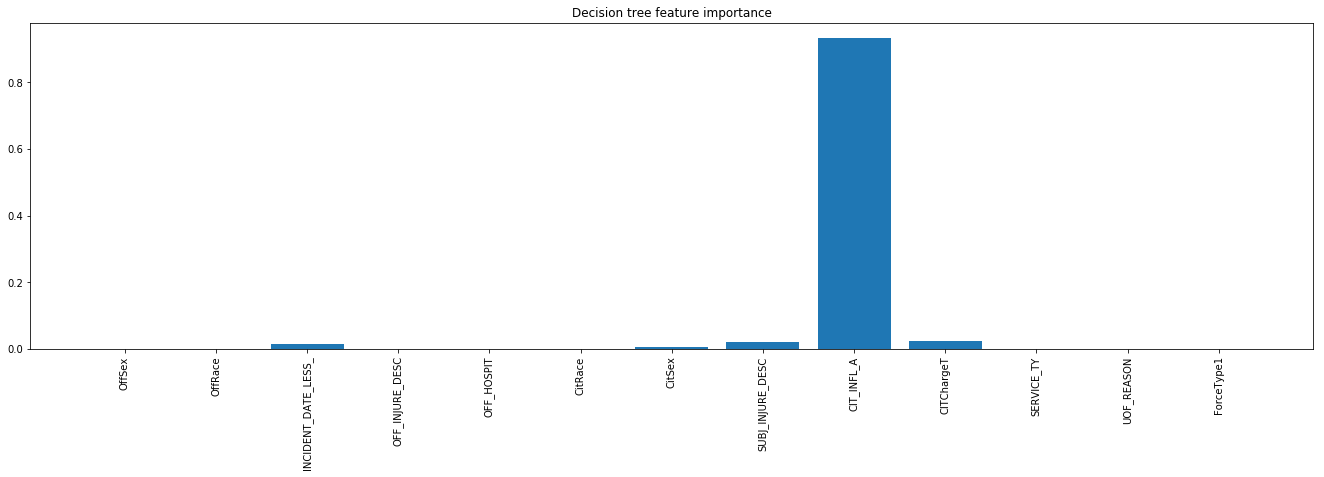

In [23]:
x = df.columns
x.remove("CIT_ARREST") #label
plt.figure(figsize=(23,6))
plt.bar(x, dtmodel.featureImportances)
plt.xticks(rotation=90)
plt.title("Decision tree feature importance")
plt.show()

Now we plot the feature importance for random forest

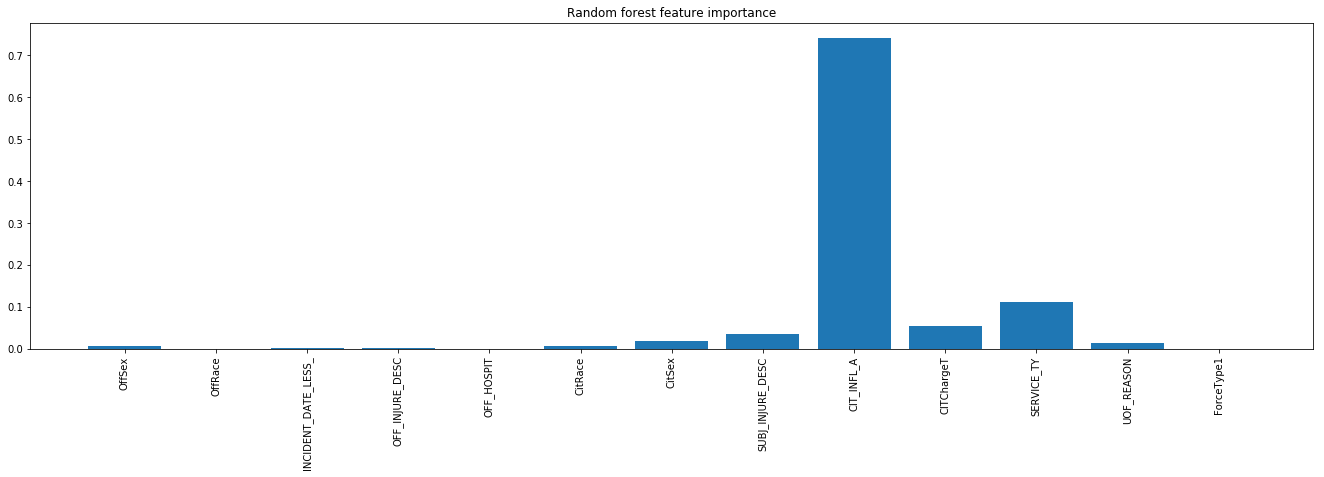

In [24]:
x = df.columns
x.remove("CIT_ARREST") #label
plt.figure(figsize=(23,6))
plt.bar(x, rfmodel.featureImportances)
plt.xticks(rotation=90)
plt.title("Random forest feature importance")
plt.show()

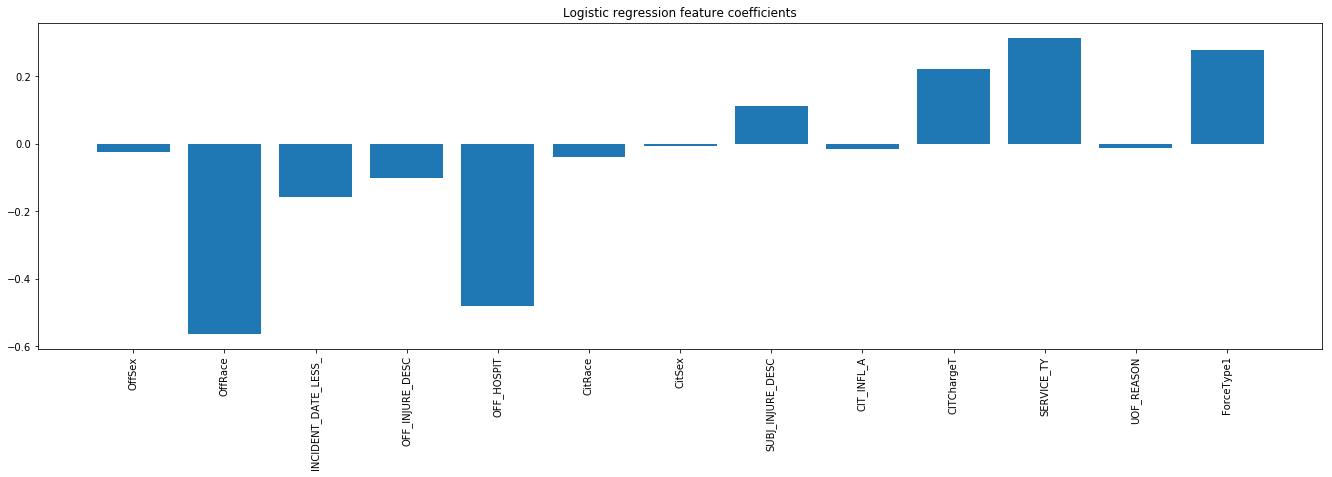

In [25]:
x = df.columns
x.remove("CIT_ARREST") #label
plt.figure(figsize=(23,6))
plt.bar(x, lrmodel.coefficients)
plt.xticks(rotation=90)
plt.title("Logistic regression feature coefficients")
plt.show()